# Gaussian quantum information

In [27]:
import qutip as qt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import pi, sqrt, exp, real, imag, cos, sin, cosh, sinh
from numpy.linalg import inv, det
# ensure you install latex via: 
# sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 175
font = {'family': 'normal', 'weight': 'bold', 'size': 16}
mpl.rc('font', **font)

def plot_wigner(Q, P, W, state_name, elev, azim):
    """
    Q: q quadrature values
    P: p quadrature values
    W: Wigner function values
    state_name: name to display for state
    elev: elevation for 3D plot view
    axim: azimuth angle for 3D plot view
    """
    fig = plt.figure(figsize=(15, 5))
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(Q, P, W, rstride=1, cstride=1, cmap='RdBu',
                       linewidth=0, antialiased=True, 
                       vmin=-1/np.pi, vmax=1/np.pi)
    
    ax.view_init(elev=elev, azim=azim)
    ax.set_ylabel(r"$p$", labelpad=7)
    ax.set_xlabel(r"$q$", labelpad=7)
    ax.set_zlabel(r"$W(q,p)$", labelpad=7)
    plt.title('Wigner function of ' + state_name)
    
    ax = fig.add_subplot(1, 2, 2)
    cont = ax.contourf(Q, P, W, levels=100, cmap='RdBu', 
                       vmin=-1/np.pi, vmax=1/np.pi)
    
    ax.set_ylabel(r"$p$")
    ax.set_xlabel(r"$q$")
    fig.colorbar(cont, shrink=0.75, aspect=20)
    plt.title('Wigner function of ' + state_name)
    plt.show()

## Classical hardness of simulating arbitrary quantum systems
Those that are familiar with the field of quantum computing know that the goal of building a quantum computer
is to have a computer capable of performing computations that are intractable for a classical computer, modeled as a deterministic Turing machine, to compute. This is due to the exponential size of the matrices required to 
describe the dynamics of quantum systems. For instance for a two-level quantum system (a qubit), such as the polarization of a photon, the states of the photon are described by $2$-dimensional vectors and the evolution of the state of the photon is described by matrices of size $2 \times 2$. 
However we wish to study systems of arbitrarily many particles and for a quantum system of $N$ qubits the state of the system is now described by $2^N$-dimensional vectors and their evolution is described by matrices of size $2^N \times 2^N$. Clearly this implies the memory overhead of classically simulating such a system is $O(2^{2N})$ which is exponential in the size of the system. The time complexity of performing such a calculation, using the standard fast matrix multiplication algorithm (Strassen), is even worse at $O(2^{2.8074N})$.

## Not all quantum systems are classically hard to simulate

Remarkably there are some classes of quantum systems that **can** be simulated efficiently with a classical computer. One of these is the class of so called Gaussian quantum systems {cite:p}`bartlett2002efficient`. These are systems of quantum harmonic oscillators whose states are all initially Gaussian states and evolve under Gaussian operations and measurement. In this context Gaussian states are quantum states whose Wigner function is a Gaussian and Gaussian operations and measurements are those that preserve the Gaussianity of the Gaussian quantum states they act on {cite:p}`weedbrook2012gaussian`. 

These processes can be simulated classically because the covariances of the position and momentum of the harmonic oscillators, which can be compactly written as a covariance matrix $\Sigma$, and the expectation values of position and momentum of the harmonic oscillators, which can be compactly written as a vector of means $\mu$, provide *complete information* about the system. For a system of $M$ oscillators $\Sigma$ is of size $2M \times 2M$ and $\mu$ is of size $2M$. The evolution of this system under Gaussian operations is described by $2M \times 2M$ symplectic matrices and given by the evolution rules {cite:p}`adesso2014continuous`

$$
\Sigma \rightarrow S\Sigma S^T, \quad \mu \rightarrow S\mu + d
$$

where $S$ is the $2M \times 2M$ symplectic matrix representing the Gaussian operation and $d$ is a $2M$-dimensional vector of displacements that describes the displacement operation. Since the size of these matrices scales like $O(M^2)$ the computation is *polynomial* in the size of the system which is tractable. Note that a symplectic matrix is a real $2n \times 2n$ matrix $A$ that satisfies 

$$
A^T \Omega A = \Omega
$$

where  $\Omega = \begin{bmatrix} 0 & I_n \\\ I_n & 0 \end{bmatrix}$ and $I_n$ is the $n \times n$ identity matrix.

The Wigner function for an $M$ mode system can also be computed in this formalism using the formula given in {cite:p}`brask2021gaussian`

$$
W(\vec{r}) = \frac{1}{2^M\pi^M\sqrt{\textrm{det}(\Sigma)}}\exp\left({-\frac{1}{2}(\vec{r}-\mu)^T \Sigma^{-1} (\vec{r}-\mu)}\right)
$$

where $\vec{r}$ is sometimes called the mode ordering vector which we define as the vector $\vec{r}=[q_1,p_1,q_2,p_2,...,q_M,p_M]$ where $q_i$ and $p_i$ are the position and momentum operators (quadratures) for the $i$-th oscillator or bosonic mode. Naturally for a single mode system we just have $\vec{r}=[q_1,p_1]$ and the Wigner function is just a function of these 2 operators/variables.

## Vacuum state

The simplest example of the Gaussian state is the vacuum state or the ground state of the quantum harmonic oscillator denoted $\ket{\psi}=\ket{0}$. It's Wigner function is a Gaussian centered at the origin of phase space meaning it has a mean of $0$ in both variables $q$ and $p$. It also has variance $\frac{1}{2}$, since we set $\hbar=1$, for the variables $q$ and $p$ {cite:p}`weedbrook2012gaussian`. It's covariance matrix and vector of means are thus

$$
\Sigma = \begin{bmatrix}
\frac{1}{2} & 0 \\
0 & \frac{1}{2} 
\end{bmatrix}, \quad \mu = \begin{bmatrix}
0 \\
0 
\end{bmatrix}.
$$

Below is some code to compute the Wigner function of an arbitrary single mode Gaussian state, in this case it will be the vacuum state. I used `NumPy` to vectorize some operations.

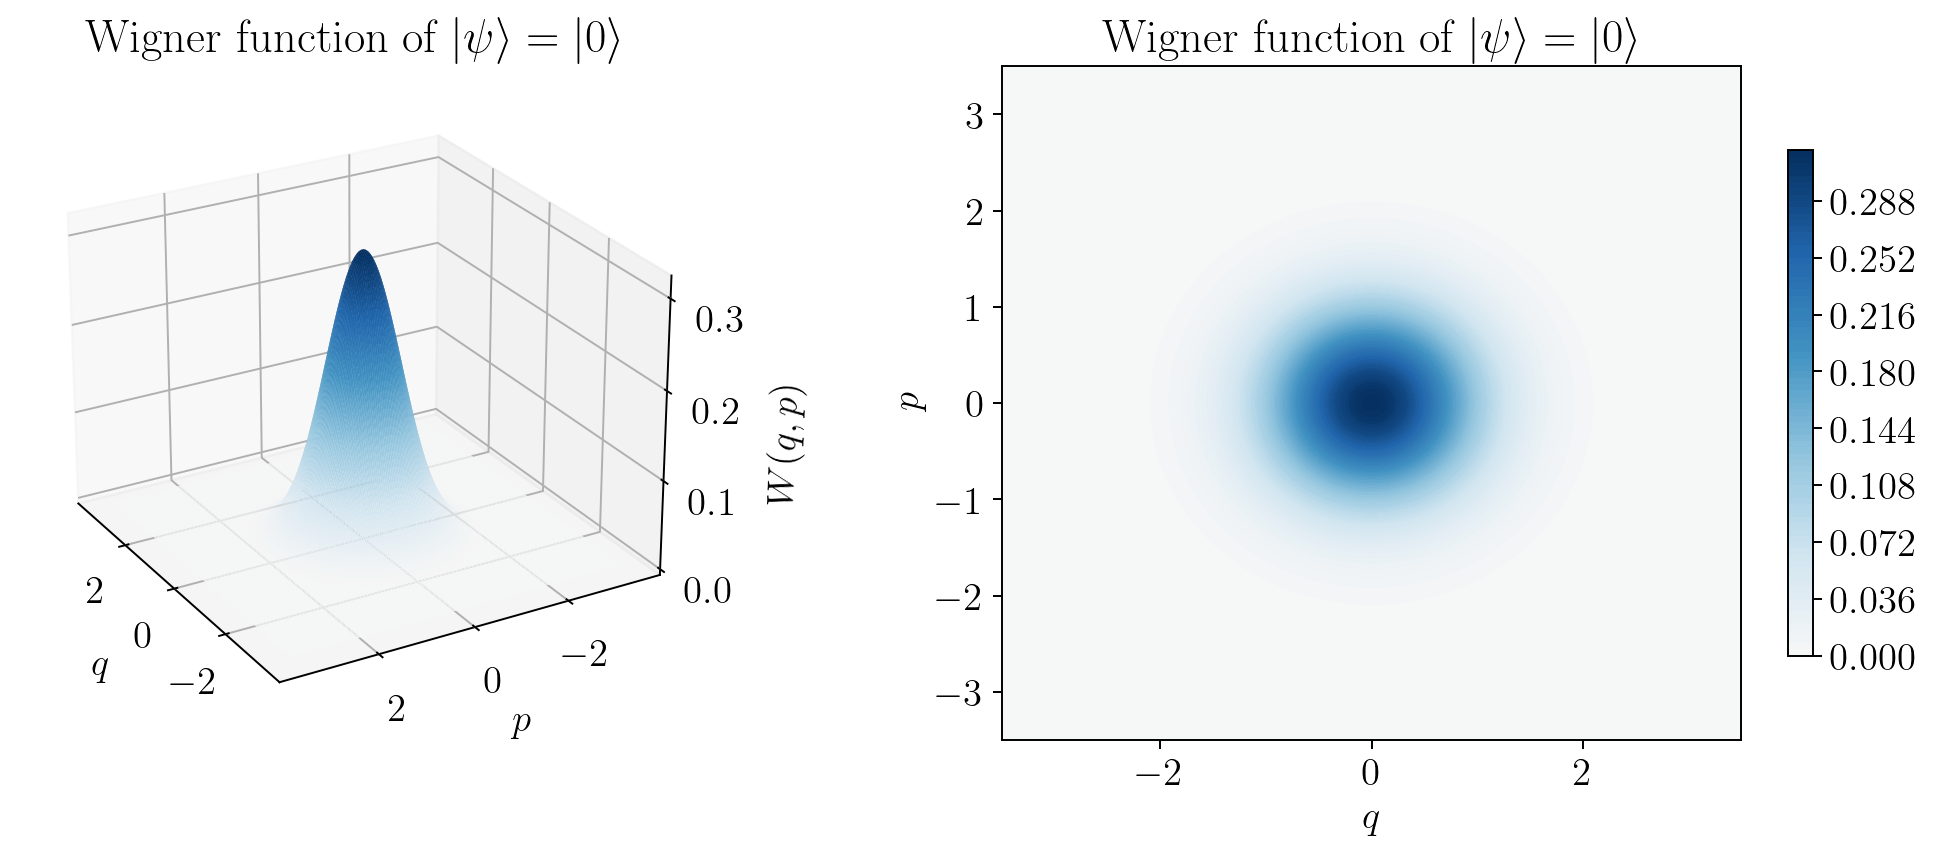

In [28]:
def wigner(sig, mu, q, p):    
    det_sig = det(sig) # determinant of covar matrix
    inv_sig = inv(sig) # inverse of covar matrix
    a = 1 / (2 * pi * sqrt(det_sig))
    R = np.stack((q, p), axis=-1)
    B = exp(-0.5 * np.sum( (R - mu) @ inv_sig * (R - mu), axis=-1 ) )
    W = a * B

    return(W)

max_quad = 3.5 # maximum quadrature value to plot
points = 200 # number of points in each quadrature
state_name = r'$|\psi\rangle=|0\rangle$'

sig = np.array( [ [0.5, 0],  
                  [0, 0.5] ] ) # covariance matrix of vacuum state
mu = np.array( [0, 0] ) # # mean vector of vacuum state

q_points = p_points = np.linspace(-max_quad, max_quad, points)
Q, P = np.meshgrid(q_points, q_points)
W = wigner(sig, mu, Q, P)
plot_wigner(Q, P, W, state_name, 25, 150)

## Examples of Gaussian operations

Now lets look at some Gaussian operations. We'll examine how each of them transform the vacuum state.

### Displacement

Probably the simplest Gaussian operation is the displacement operations which simply translates the Wigner function in phase space by changing the expectation value of the state in the 2 quadratures. In the Fock basis the displacement operation has the form

$$
D(\alpha) = e^{\alpha a^\dagger - \alpha^* a}.
$$

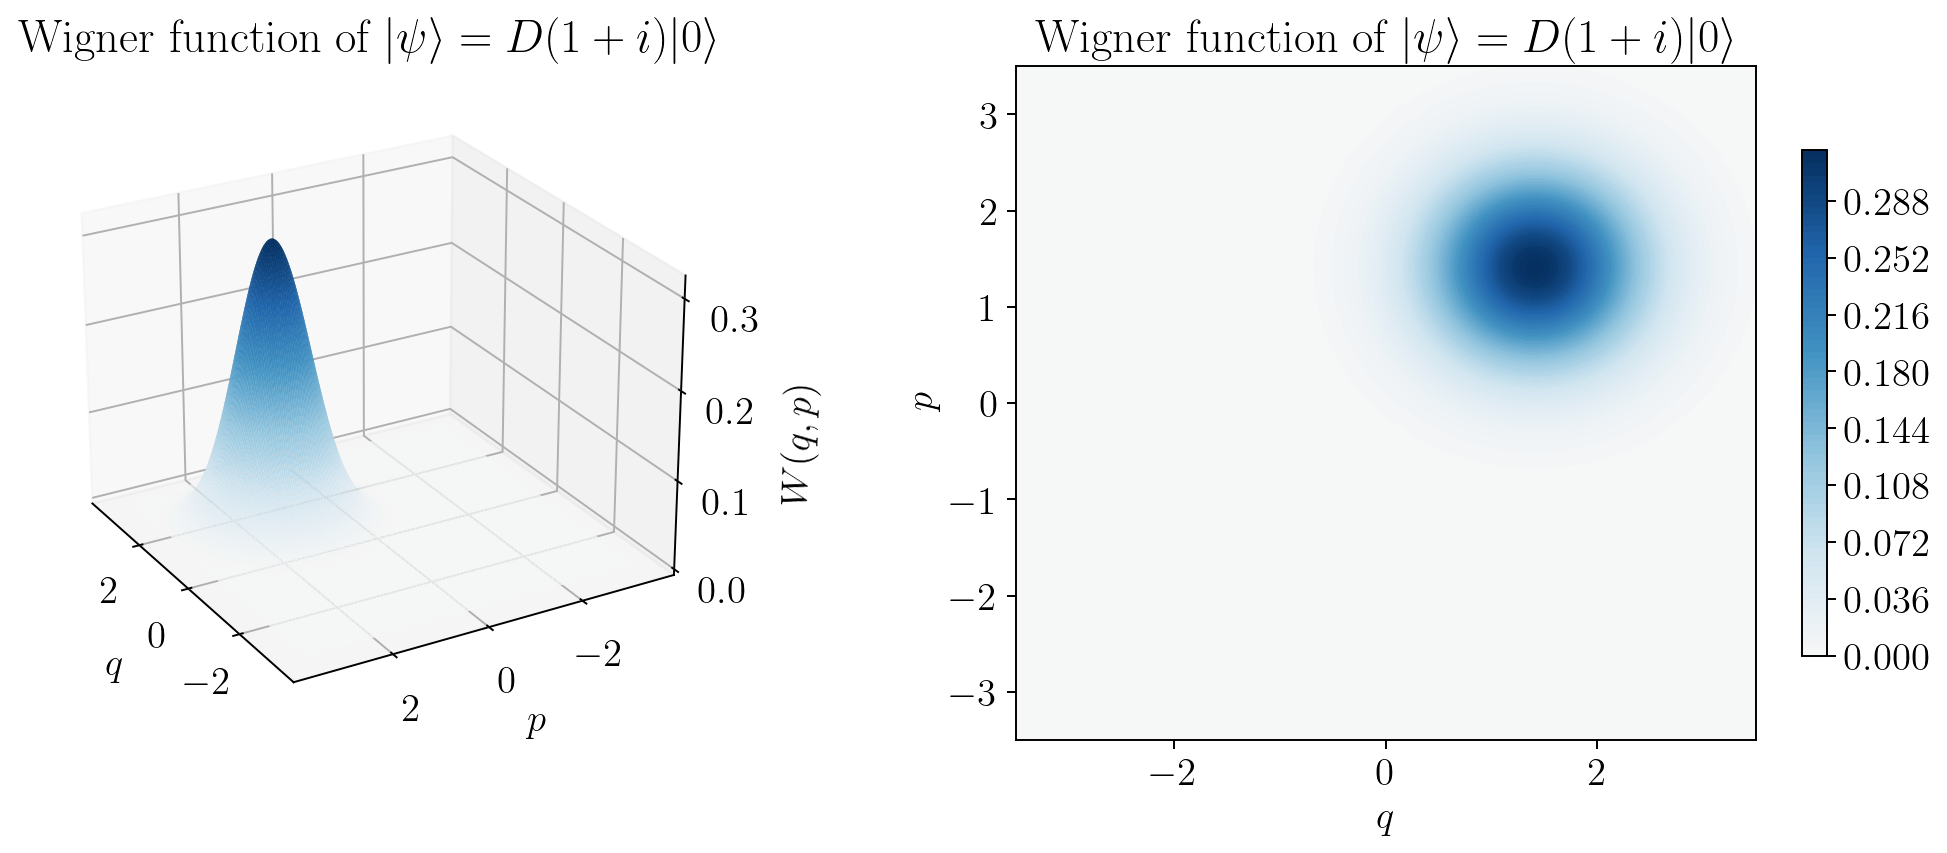

In [66]:
def displacement(alpha):
    d = sqrt(2) * np.array( [ real(alpha), imag(alpha) ] )
    return(d)

state_name = r'$|\psi\rangle=D(1+i)|0\rangle$'

sig = np.array( [ [0.5, 0],  
                  [0, 0.5] ] ) # covariance matrix of vacuum state
mu = np.array( [0, 0] ) # # mean vector of vacuum state

alpha = 1 + 1j
d = displacement(alpha)
mu = mu + d

q_points = p_points = np.linspace(-max_quad, max_quad, points)
Q, P = np.meshgrid(q_points, q_points)
W = wigner(sig, mu, Q, P)
plot_wigner(Q, P, W, state_name, 25, 150)

### Phase shift (rotation)

Another Gaussian operation is the phase shift (rotation) operation which simply rotates the Wigner function in phase space. For this operation we'll look at how it transforms the coherent state shown above as the vacuum state is invariant under rotation. 

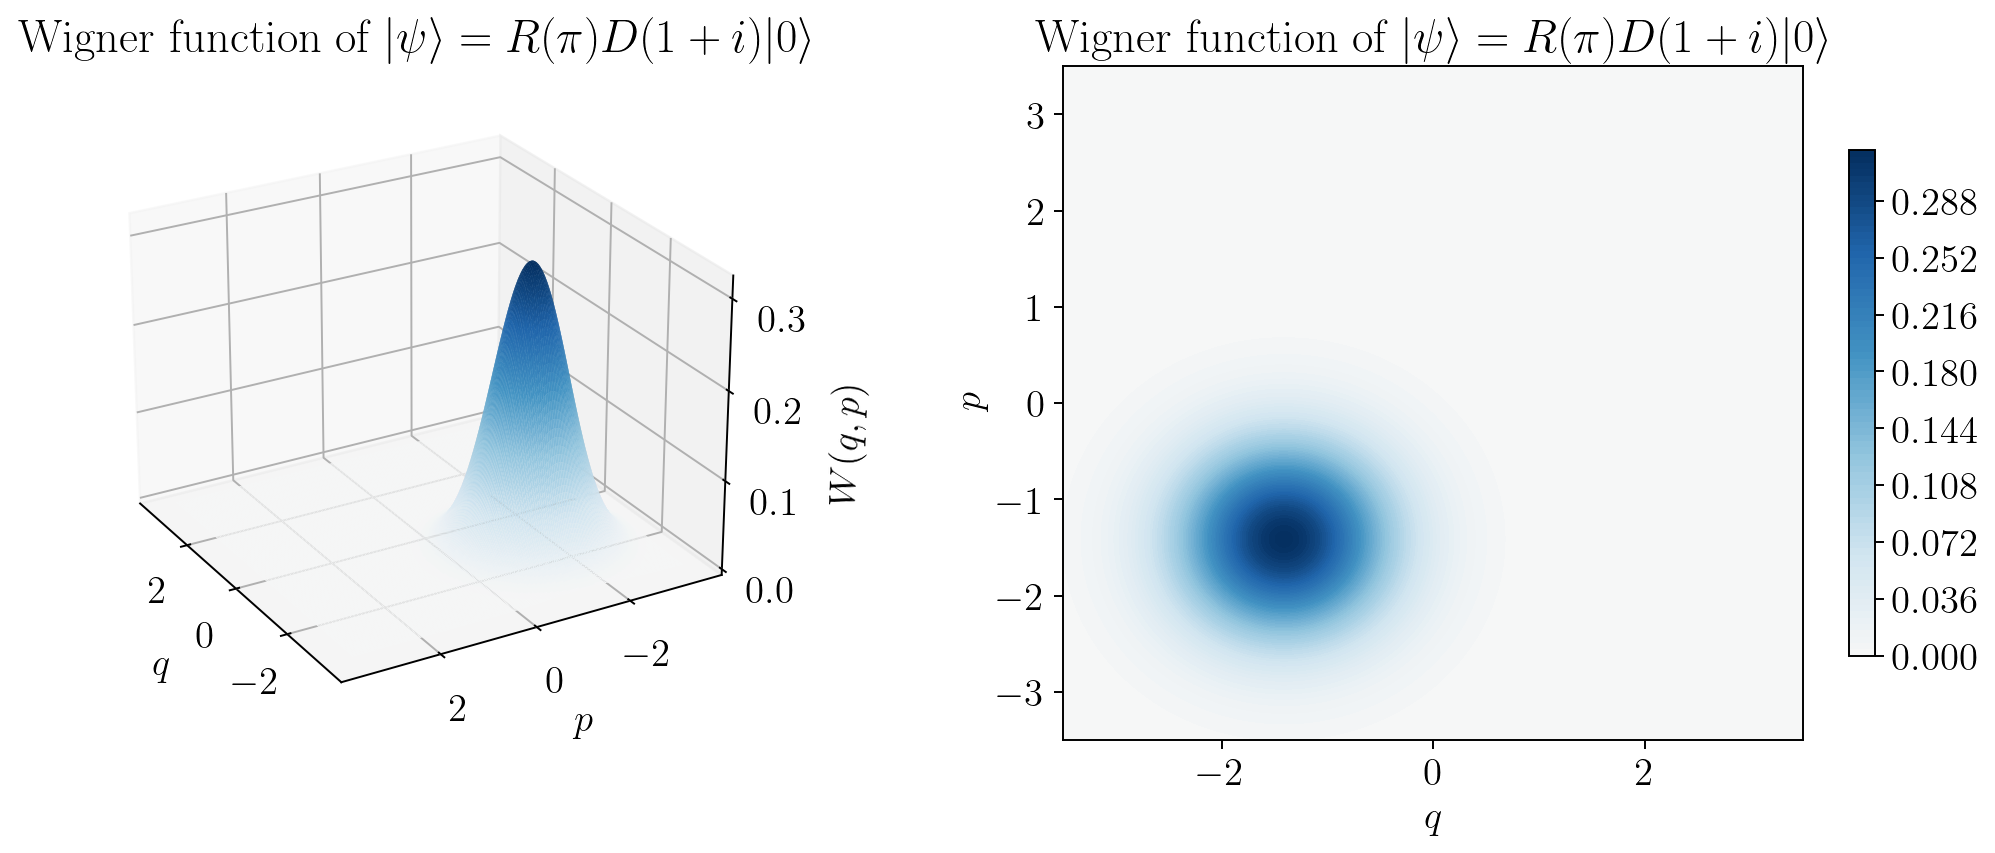

In [67]:
def phase_shift(theta):
    R = np.array( [ [ cos(theta), sin(theta) ],
                    [ -sin(theta), cos(theta) ] ] )
    return(R)

state_name = r'$|\psi\rangle=R(\pi)D(1+i)|0\rangle$'

sig = np.array( [ [0.5, 0],  
                  [0, 0.5] ] ) # covariance matrix of vacuum state
mu = np.array( [0, 0] ) # # mean vector of vacuum state

R = phase_shift(pi)
d = displacement(alpha)
sig = R @ sig @ R.T
mu = R @ (mu + d)

q_points = p_points = np.linspace(-max_quad, max_quad, points)
Q, P = np.meshgrid(q_points, q_points)
W = wigner(sig, mu, Q, P)
plot_wigner(Q, P, W, state_name, 25, 150)

### Squeezing

Another Gaussian operation is the squeezing operation which simply squeezes the Wigner function in phase space and thus reduces the variance (uncertainty) in one of the quadratures and increases the variance in another. For this operation we'll look at how it transforms the vacuum. 

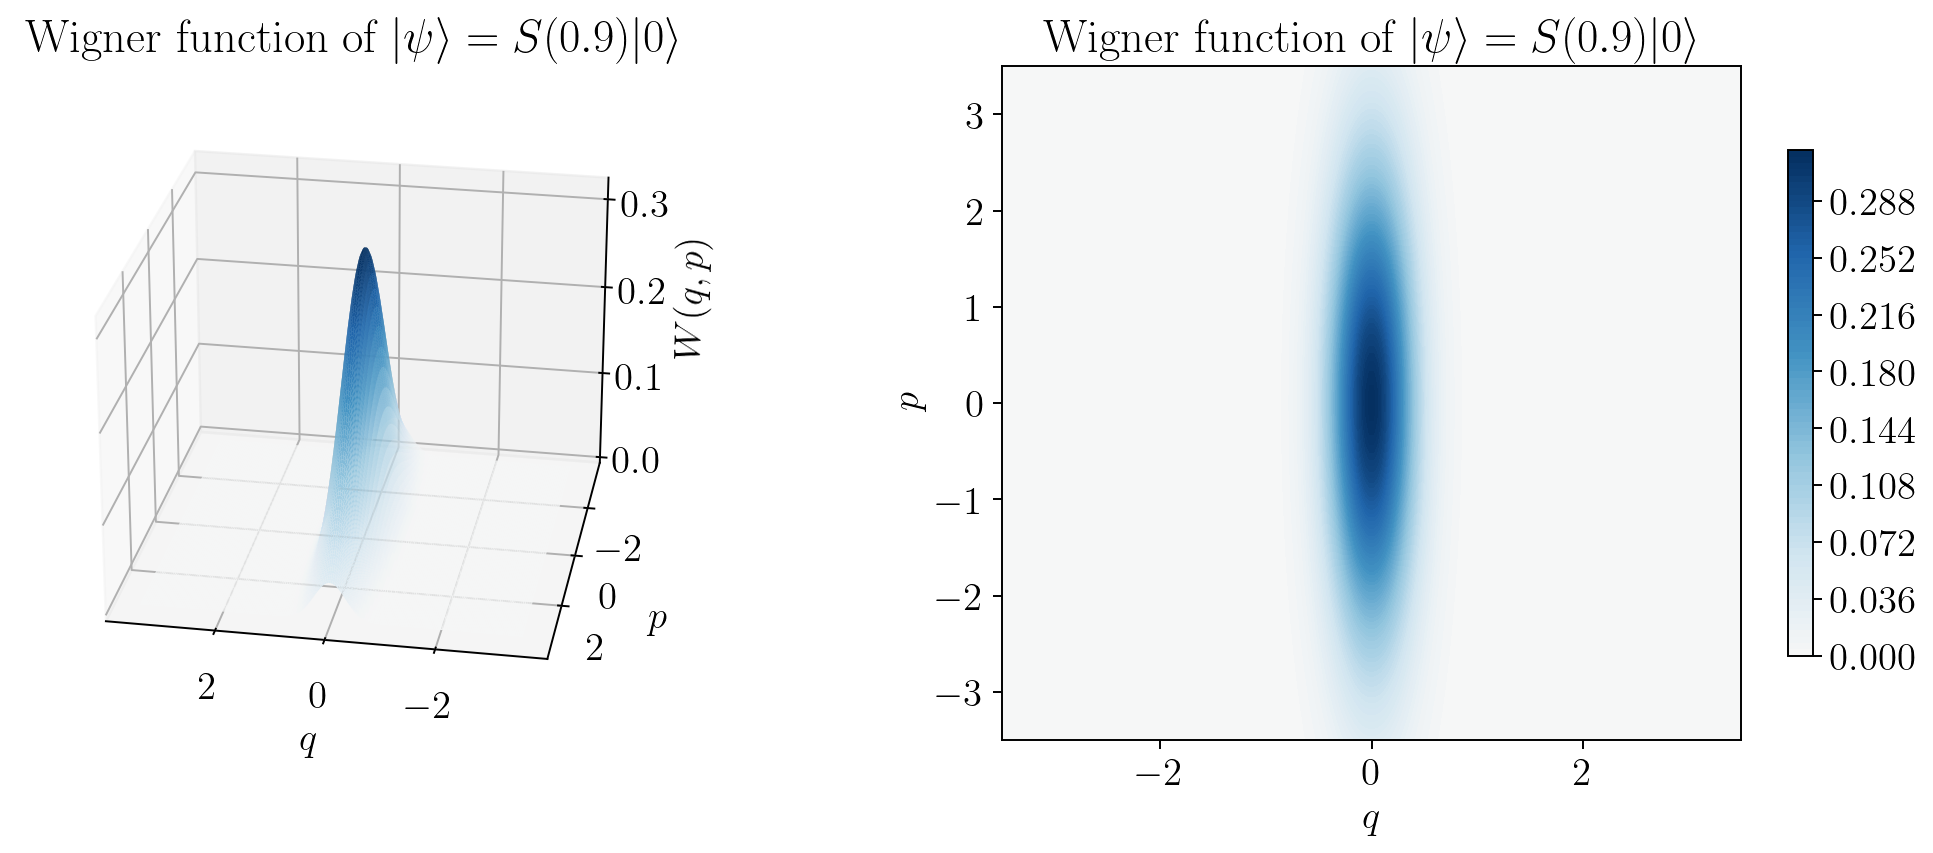

In [65]:
def squeeze(r, theta):
    I = np.eye(2)
    A = np.array( [ [ cos(theta), sin(theta) ],
                    [ sin(theta), -cos(theta) ] ] )
    S = cosh(r) * I - sinh(r) * A
    return(S)

state_name = r'$|\psi\rangle=S(0.9)|0\rangle$'

sig = np.array( [ [0.5, 0],  
                  [0, 0.5] ] ) # covariance matrix of vacuum state
mu = np.array( [0, 0] ) # mean vector of vacuum state


S = squeeze(0.9, 0)
sig = S @ sig @ S.T
mu = S @ mu

q_points = p_points = np.linspace(-max_quad, max_quad, points)
Q, P = np.meshgrid(q_points, q_points)
W = wigner(sig, mu, Q, P)
plot_wigner(Q, P, W, state_name, 25, 100)

## Other examples of Gaussian states

### Thermal state
Another example of a Gaussian state is a thermal state which is a mixed state defined as {cite:p}`weedbrook2012gaussian`

$$
\rho(\bar{n}) = \sum_{n=0}^{\infty} \frac{\bar{n}^n}{(\bar{n} + 1)^{n+1}}\ket{n}\bra{n}.
$$

These states are interesting since they are not pure states and like the vacuum state have 0 expectation value in both quadratures. However unlike the vacuum state they have a variance of $2\bar{n}+1$ for the two quadratures as can be seen from the below Wigner plot which is a Gaussian with wider spread along both variables.

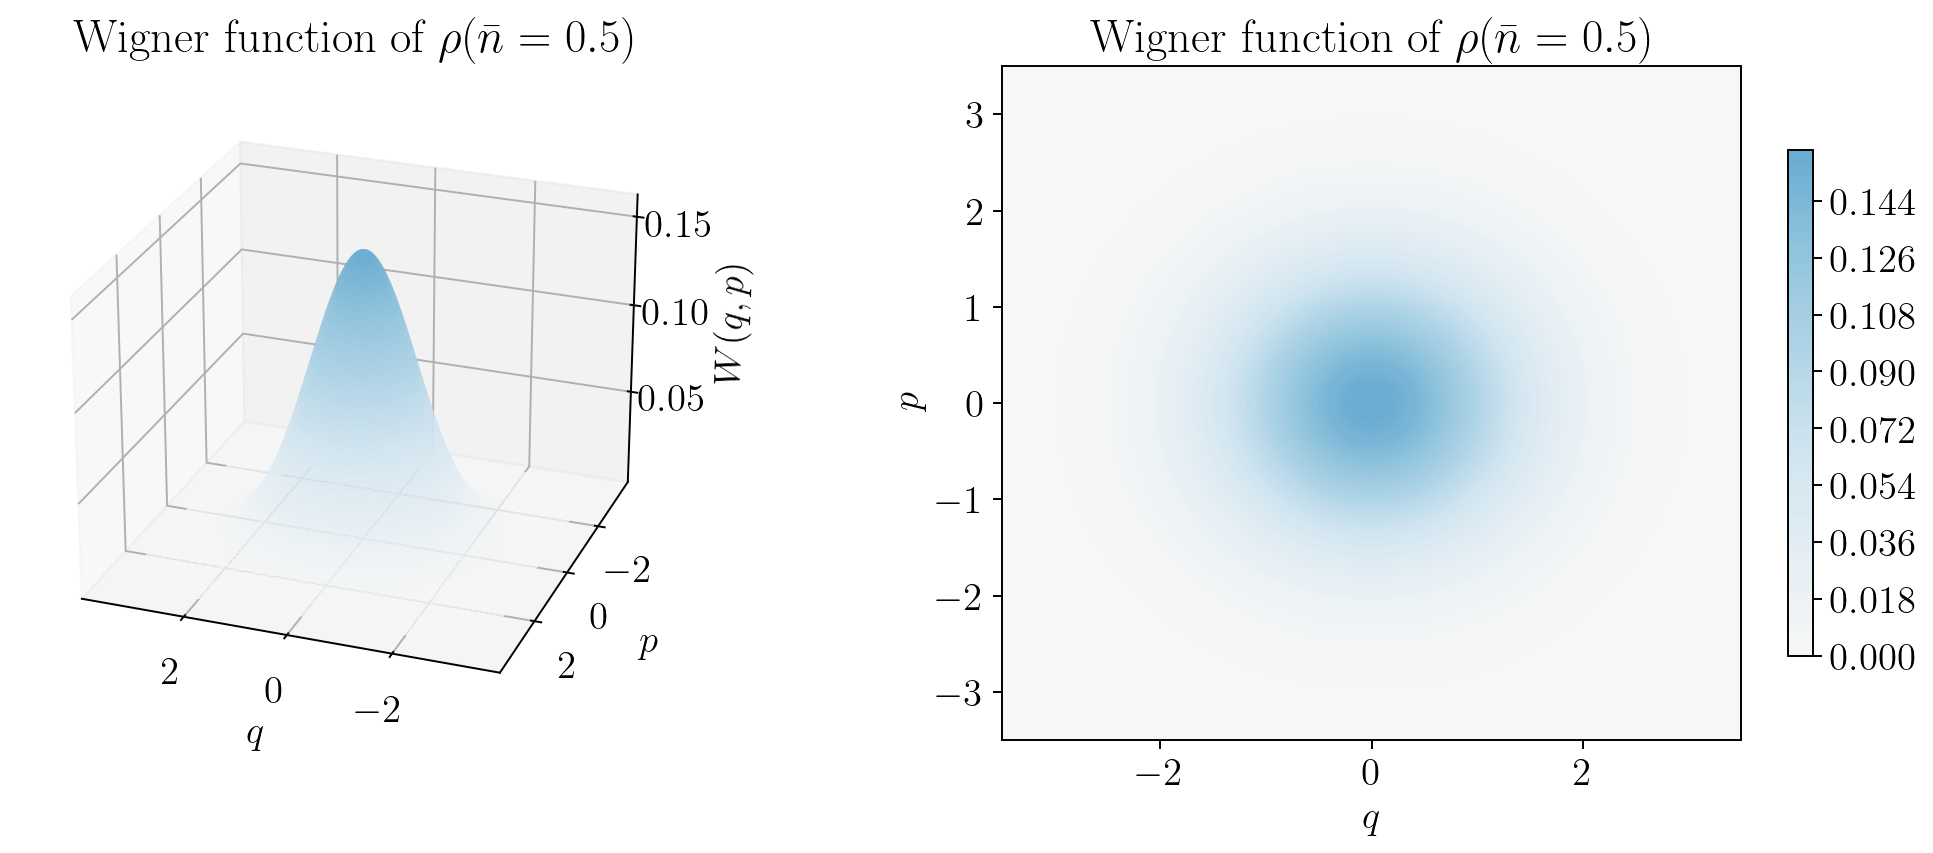

In [40]:
state_name = r'$\rho(\bar{n}=0.5)$'
nbar = .5

sig = np.array( [ [nbar + 0.5, 0],  
                  [0, nbar + 0.5] ] ) # covariance matrix of vacuum state

mu = np.array( [0, 0] ) # mean vector of vacuum state

W = wigner(sig, mu, Q, P)
plot_wigner(Q, P, W, state_name, 25, 110)

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Thu Jul 04 2024

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.22.2

numpy     : 1.26.2
qutip     : 4.7.5
matplotlib: 3.7.4

